## 1. Сгенерировать пакетом hopfield-tracking датасет spdsim с параметрами по умолчанию

In [ ]:
import vispy
# selecting sub-backend behind jupyter_rfb:
# 1) pyglfw has high priority if present
# 2) to use any other backend, install then designate as default
# 4) use jupyter_rfb, it then selects the sub-backend according to config
# 5) enable jupyterlab extensions for interactive widget provided by jupyter_rfb

# only needed in jhub2, jhub and jlab-hpc can't run opengl at all, locally auto-selected backend is OK
vispy.config.update(default_backend='egl')
vispy.use('jupyter_rfb')

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
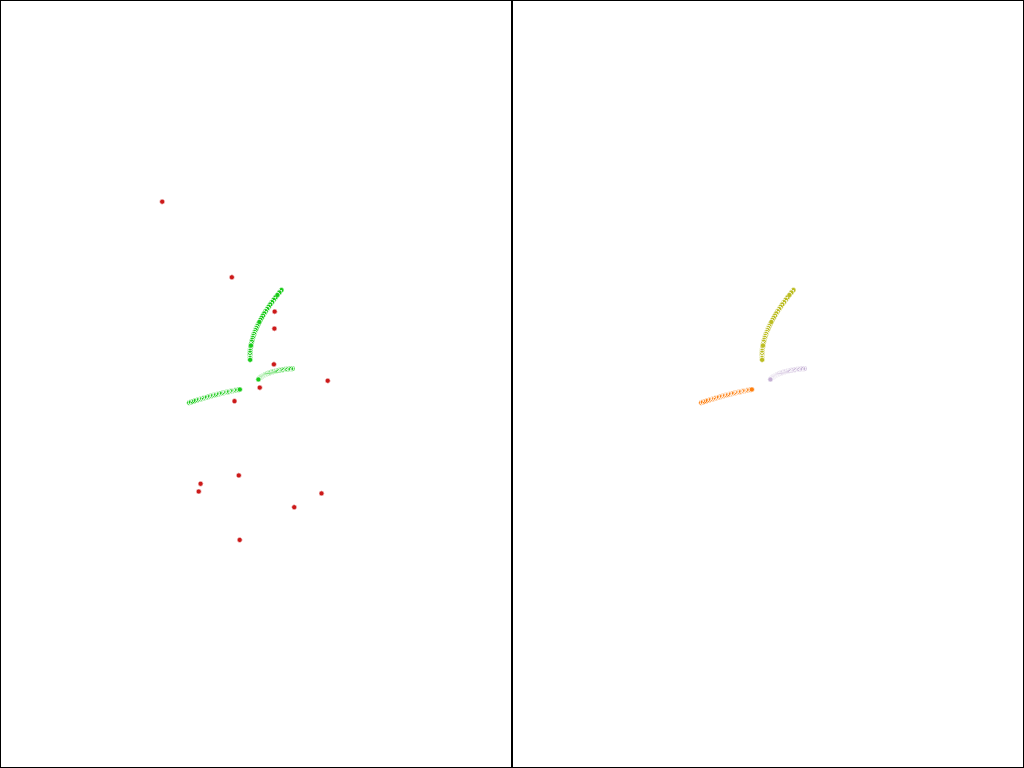

In [ ]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event = get_hits('spdsim', 1)
plot_event(event)

In [ ]:
event

,x,y,z,layer,track,event_id
0,193.815497,-187.972238,-104.745437,1,0,0
1,200.285952,-205.638740,-109.063967,2,0,0
2,205.648295,-224.051984,-113.267063,3,0,0
3,210.210628,-242.829841,-117.454628,4,0,0
4,213.693258,-262.221678,-121.642656,5,0,0
...,...,...,...,...,...,...
256,-66.901813,470.009137,-2266.595653,12,-1,0
257,235.346500,-132.306791,-1241.773186,0,-1,0
258,-238.309352,-370.581610,-1885.612386,10,-1,0
259,-288.969912,439.258185,-2208.802405,15,-1,0


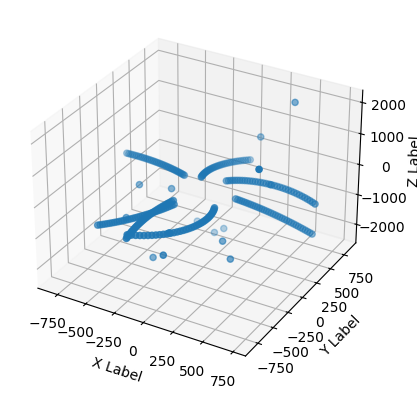

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_event(df):
    # Создание фигуры и осей
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Генерация данных
    x = df['x']
    y = df['y']
    z = df['z']

    # Построение графика
    ax.scatter(x, y, z)

    # Настройка осей
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Отображение графика
    plt.show()

draw_event(event)

## 2. Добавить цилиндрические координаты хитов вокруг оси z

In [ ]:
from tracking.hit import add_cylindric_coordinates

add_cylindric_coordinates(event)

,x,y,z,layer,track,event_id,r,phi
0,193.815497,-187.972238,-104.745437,1,0,0,269.996313,-0.770094
1,200.285952,-205.638740,-109.063967,2,0,0,287.057057,-0.798584
2,205.648295,-224.051984,-113.267063,3,0,0,304.122530,-0.828201
3,210.210628,-242.829841,-117.454628,4,0,0,321.177272,-0.857275
4,213.693258,-262.221678,-121.642656,5,0,0,338.267670,-0.887016
...,...,...,...,...,...,...,...,...
256,-66.901813,470.009137,-2266.595653,12,-1,0,474.746713,1.712188
257,235.346500,-132.306791,-1241.773186,0,-1,0,269.987151,-0.512145
258,-238.309352,-370.581610,-1885.612386,10,-1,0,440.592870,-2.142283
259,-288.969912,439.258185,-2208.802405,15,-1,0,525.786423,2.152676


## 3. Реализовать с помощью любого метода машинного обучения классификацию хитов на настоящие и шумовые. Визуализировать результат для одного тестового события.

Для того чтобы получить f1_score классификации добавим в dataframe event столбец color.
В него будут записываться значения 0 (точки красного цвета т.е. шумы) и 1 (точки зеленого цвета).
Для этого в файл hopfield-tracking/tracking/plot.py добавим функцию color_to_event.
"""
    def color_to_event(event, color):
    color_list = []
    for row in color:
    	if (row == [.8, .1, .1]).all():
        	color_list.append(0)
    	else:
        	color_list.append(1)

    event['color'] = color_list
"""

Вызывать функцию будем в функции plot_event сразу после получения цветов точек.

"""
    def plot_event(event: pd.DataFrame, seg: np.ndarray = None, kdims: Iterable = ('x', 'y', 'z'),
               fig_size: Tuple[int, int] = (1024, 768)) -> SceneCanvas:
    kdims = list(kdims)
    canvas = SceneCanvas(bgcolor='white', size=fig_size)
    grid = canvas.central_widget.add_grid()

    color = np.where((event.track.to_numpy() == -1)[..., np.newaxis], [.8, .1, .1], [.1, .8, .1])

	color_to_event(event, color)

    fakes_view = _hits_view(event, kdims, color)
    grid.add_widget(fakes_view)

    cmap = colormap.MatplotlibColormap('tab20')
    event = event[event.track != -1]
    track_enum = {t: np.random.rand() for t in event.track.unique()}
    color = cmap.map(event.track.map(track_enum))
    track_view = _hits_view(event, kdims, color, fakes_view.camera)
    grid.add_widget(track_view)

    if seg is not None:
        seg_view = _seg_view(event, seg, kdims, camera=fakes_view.camera)
        grid.add_widget(seg_view)
    return canvas

"""

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
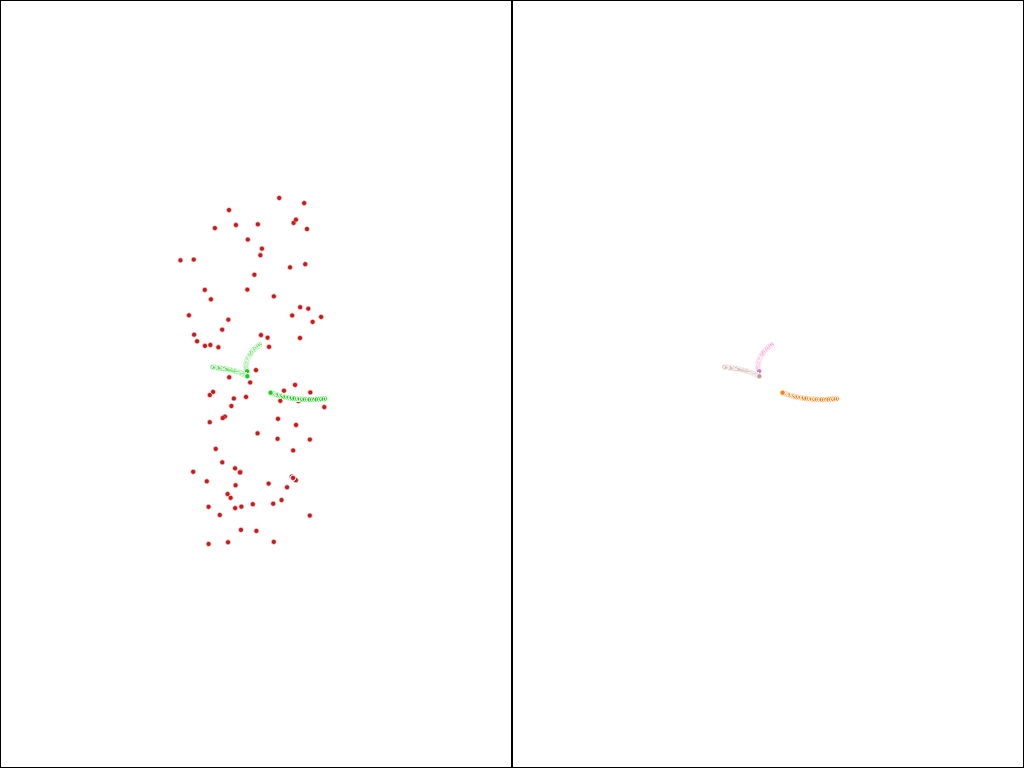

In [ ]:
from tracking.hit import add_cylindric_coordinates

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event = get_hits('spdsim', 1)
add_cylindric_coordinates(event)
plot_event(event)

In [ ]:
event

,x,y,z,layer,track,event_id,r,phi,color
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,1
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,1
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,1
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,1
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,1
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,0
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,0
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,0
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,0


In [ ]:
event.to_csv('hits_filter.csv', index=False)

In [40]:
import pandas as pd

df = pd.read_csv('hits_filter.csv')
df

,x,y,z,layer,track,event_id,r,phi,color
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,1
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,1
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,1
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,1
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,1
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,0
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,0
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,0
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,0


In [41]:
event = df.drop('color', axis=1)
event

,x,y,z,layer,track,event_id,r,phi
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479
...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727


### GaussianMixture

In [42]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)

gmm.fit(event)

labels = gmm.predict(event)

event['cluster'] = labels

In [43]:
event

,x,y,z,layer,track,event_id,r,phi,cluster
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,0
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,0
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,0
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,0
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,0
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,1
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,1
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,1
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,1


In [44]:
df1 = event.loc[event['cluster'] == 1]
df0 = event.loc[event['cluster'] == 0]

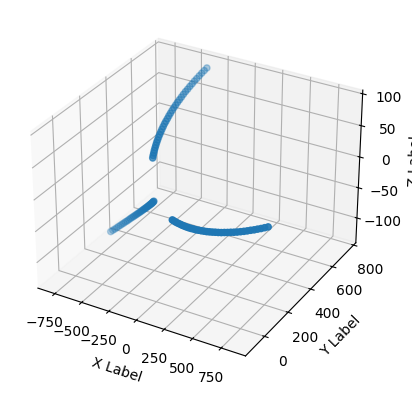

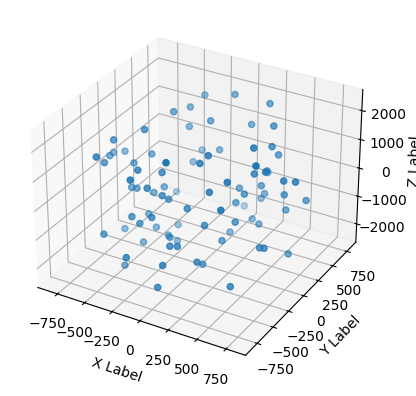

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def draw_event(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    x = df['x']
    y = df['y']
    z = df['z']


    ax.scatter(x, y, z)


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

draw_event(df0)
draw_event(df1)

In [47]:
color_mixture = event['cluster'].to_numpy()
color_mixture

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [48]:
fixed_arr = 1 - color_mixture
fixed_arr

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### HDBSCAN

In [18]:
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=10)

labels = clusterer.fit_predict(event)

event['cluster'] = labels

In [19]:
event

,x,y,z,layer,track,event_id,r,phi,cluster
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,0
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,0
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,0
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,0
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,0
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,1
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,-1
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,1
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,-1


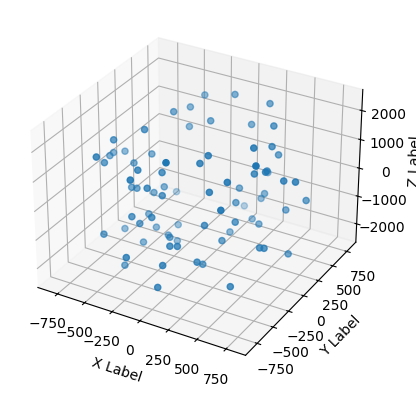

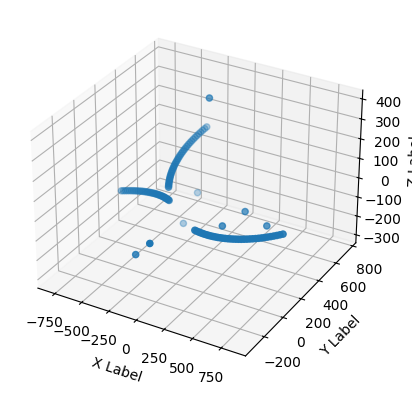

In [20]:
df1 = event.loc[event['cluster'] >= 0]
df0 = event.loc[event['cluster'] == -1]

draw_event(df0)
draw_event(df1)

## 4. Посчитать f1_score классификации на тестовом датасете spdsim с параметрами по умолчанию

In [33]:
df

,x,y,z,layer,track,event_id,r,phi,color
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,1
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,1
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,1
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,1
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,1
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,0
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,0
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,0
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,0


In [35]:
color_true = df['color'].to_numpy()
color_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [49]:
import numpy as np
from sklearn.metrics import f1_score

f1 = f1_score(color_true, fixed_arr)

print(f1)

1.0
